# Name: Fru Nkimbeng Christian 
### Banner id: 916-463-968
### Data Preparation and Understanding 
### Programming Assignment 1

## Q2 

In [1]:
import os
from PIL import Image
import numpy as np
from pathlib import Path
from skimage import filters, exposure, color, io
from sklearn.metrics import pairwise_distances
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
images_dir = Path('/Users/apple/Downloads/data_mining/Images')
annotation_dir = Path('/Users/apple/Downloads/data_mining/Annotation')

In [3]:
def list_directories(path):
    try:
        # List all directories inside the specified path
        directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        return directories
    except FileNotFoundError:
        return "The specified path does not exist."
    except Exception as e:
        return f"An error occurred: {e}"

In [4]:
images_subdir = list_directories(images_dir)
annotation_subdir = list_directories(annotation_dir)

In [5]:
print("Directories in images folder:", images_subdir)
print("\nDirectories in annotations folder:", annotation_subdir)

Directories in images folder: ['n02102318-cocker_spaniel', 'n02106382-Bouvier_des_Flandres', 'n02107574-Greater_Swiss_Mountain_dog', 'n02105056-groenendael']

Directories in annotations folder: ['n02102318-cocker_spaniel', 'n02106382-Bouvier_des_Flandres', 'n02107574-Greater_Swiss_Mountain_dog', 'n02105056-groenendael']


In [6]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


### Cropping and Resize Images in  4 classes and resizing each image to a 128×128 pixel image

In [7]:
# Function to get bounding boxes from annotations
def get_bounding_boxes(annot_path):
    tree = ET.parse(annot_path)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

In [8]:
# Process each subdirectory to crop and save images
for subdir in images_subdir:
    # Paths to image and annotation subdirectories
    img_subdir_path = images_dir / subdir
    annot_subdir_path = annotation_dir / subdir

    # Check if the annotation subdirectory exists
    if not annot_subdir_path.exists():
        print(f"Directory not found: {annot_subdir_path}")
        continue  # Skip this subdirectory if it doesn't exist

    # Get all image and XML annotation files in the respective subdirectories
    images = [img_subdir_path / f for f in os.listdir(img_subdir_path)]
    annotations = [annot_subdir_path / f for f in os.listdir(annot_subdir_path)]

    for i, annot in enumerate(annotations):
        bbox = get_bounding_boxes(annot)  # Get bounding boxes from the XML annotation
        dog_image_path = images[i]  # Get corresponding image path
        im = Image.open(dog_image_path)  # Open the image

        # Assuming that image filename is the same as annotation filename but with .jpg extension
        for j, box in enumerate(bbox):
            im2 = im.crop(box)  # Crop the image using the bounding box
            im2 = im2.resize((128, 128))  # Resize the cropped image

            # Define the new path for the cropped image
            new_path = str(dog_image_path).replace(str(images_dir), './Cropped').replace('.jpg', f'-{j}.jpg')
            head, tail = os.path.split(new_path)

            # Create the directory if it does not exist
            Path(head).mkdir(parents=True, exist_ok=True)

            # Save the cropped image
            im2.save(new_path)


### b. Histogram Equalisation (image intensity Normalisation chooseing 1 images from each class)

In [9]:
cropped_dir = Path('./cropped')

In [10]:
# Manually selected images (as requested)
selected_images = {
    "n02102318-cocker_spaniel": ["/Users/apple/Downloads/data_mining/Cropped/n02102318-cocker_spaniel/n02102318_8406-0.jpg"],
    "n02106382-Bouvier_des_Flandres": ["/Users/apple/Downloads/data_mining/Cropped/n02106382-Bouvier_des_Flandres/n02106382_1381-0.jpg"],
    "n02107574-Greater_Swiss_Mountain_dog": ["/Users/apple/Downloads/data_mining/Cropped/n02107574-Greater_Swiss_Mountain_dog/n02107574_1415-0.jpg"],
    "n02105056-groenendael": ["/Users/apple/Downloads/data_mining/Cropped/n02105056-groenendael/n02105056_4846-0.jpg"]
}

In [11]:
# Store selected images from class
selected_images = {}

for subdir in cropped_dir.iterdir():
    if subdir.is_dir():
        # List all files in the subdirectory
        images_files = list(subdir.glob('*.jpg'))

        # Choose 1 image
        if len(images_files) >= 1:
            selected_images[subdir.name] = images_files[:1]  # Select the first image
        else:
            print(f"Warning: Less than 1 image found {subdir.name}")

In [12]:
# print selected images
for class_name, images in selected_images.items():
    print(f"Class: {class_name}")
    for img in images:  
        print(img)  
    print('' * 30)  

Class: n02102318-cocker_spaniel
cropped/n02102318-cocker_spaniel/n02102318_10162-0.jpg

Class: n02106382-Bouvier_des_Flandres
cropped/n02106382-Bouvier_des_Flandres/n02106382_501-0.jpg

Class: n02107574-Greater_Swiss_Mountain_dog
cropped/n02107574-Greater_Swiss_Mountain_dog/n02107574_173-0.jpg

Class: n02105056-groenendael
cropped/n02105056-groenendael/n02105056_6661-0.jpg



In [13]:
# Function to display color and grayscale images side by side
def display_images(image_path):
    img = Image.open(image_path)
    gray_img = img.convert('L')

    # Create a figure for displaying side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'{class_name} -Color and Grayscale Comparison', fontsize=16)

    # Display color image
    ax[0].imshow(img)
    ax[0].set_title('Colored')
    ax[0].axis('off')

    # Display grayscale image
    ax[1].imshow(gray_img, cmap='gray')
    ax[1].set_title('Grayscale')
    ax[1].axis('off')

    plt.show()

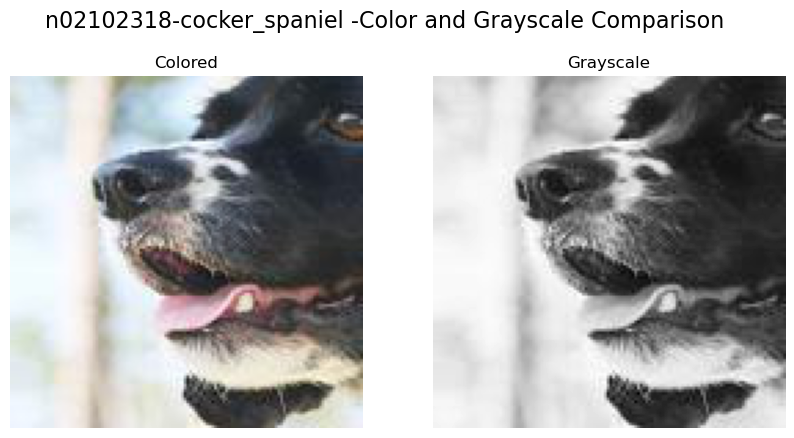

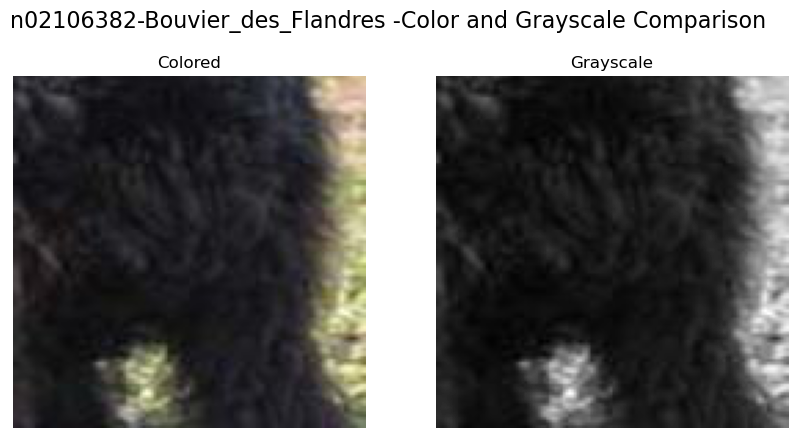

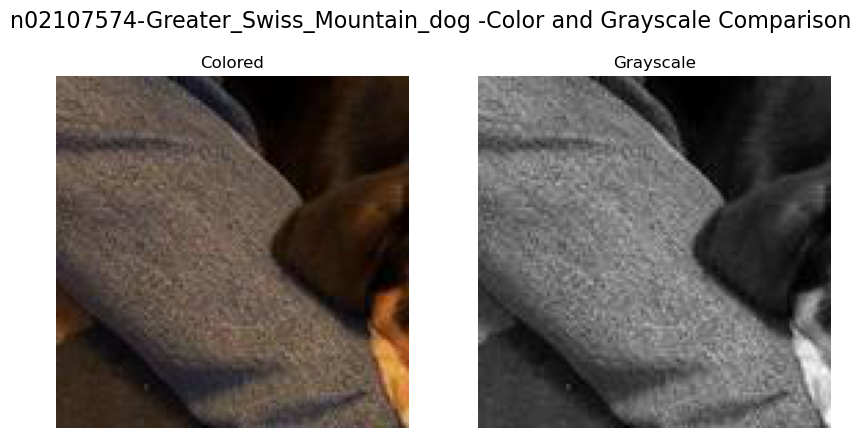

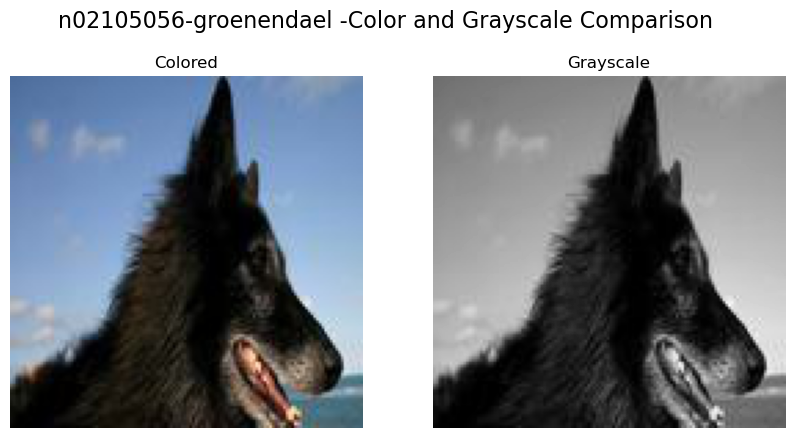

In [14]:
# Iterate over selected images and display them
for class_name, images in selected_images.items():
    for img_path in images:
        display_images(img_path)  # Display color and grayscale images side by side

### Calculating the angle of the edge gradient

In [15]:
# Function to calculate the angle of the edge gradient
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)  # Return angle in radians

In [16]:
# Function to process and display the edge histogram for each image
def process_image_for_histogram(image_path):
    # Open the image and convert to grayscale
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)  # Convert to NumPy array for processing

    # Calculating Sobel horizontal and vertical gradients
    sobel_h = filters.sobel_h(img_np)
    sobel_v = filters.sobel_v(img_np)

    # Calculating the gradient angle at each pixel
    angle_sobel = angle(sobel_h, sobel_v)

    # Compute the histogram with 36 bins for the gradient angles
    hist, hist_centers = exposure.histogram(angle_sobel, nbins=36)

    # Plotting the image and its corresponding edge histogram
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting the grayscale image
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f"Grayscale Image: {image_path.name}")
    ax[0].axis('off')

    # Plot the edge angle histogram
    ax[1].bar(hist_centers, hist, width=np.diff(hist_centers)[0])
    ax[1].set_title(f"Edge Angle Histogram for: {image_path.name}")
    ax[1].set_xlabel("Bins")
    ax[1].set_ylabel("Pixel Count")

    plt.tight_layout()
    plt.show()

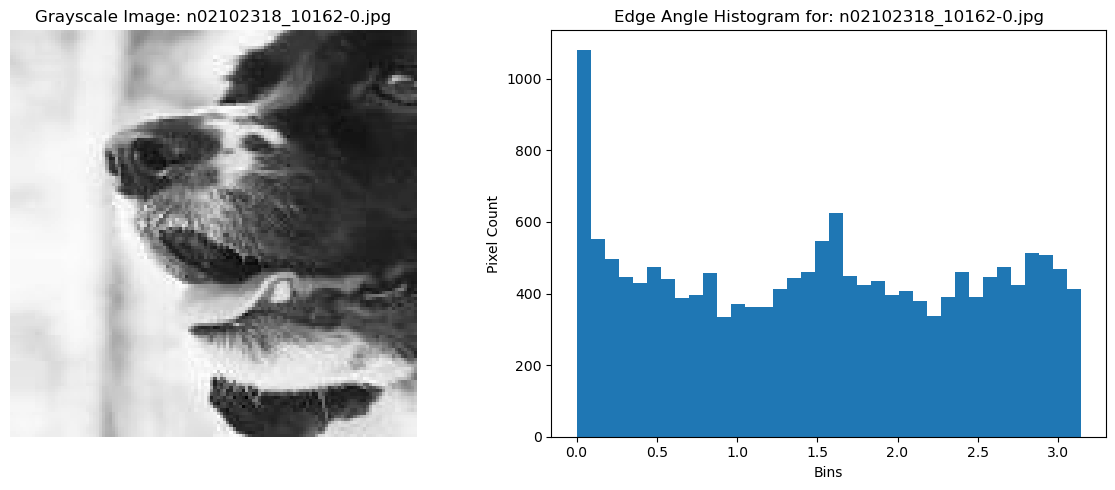

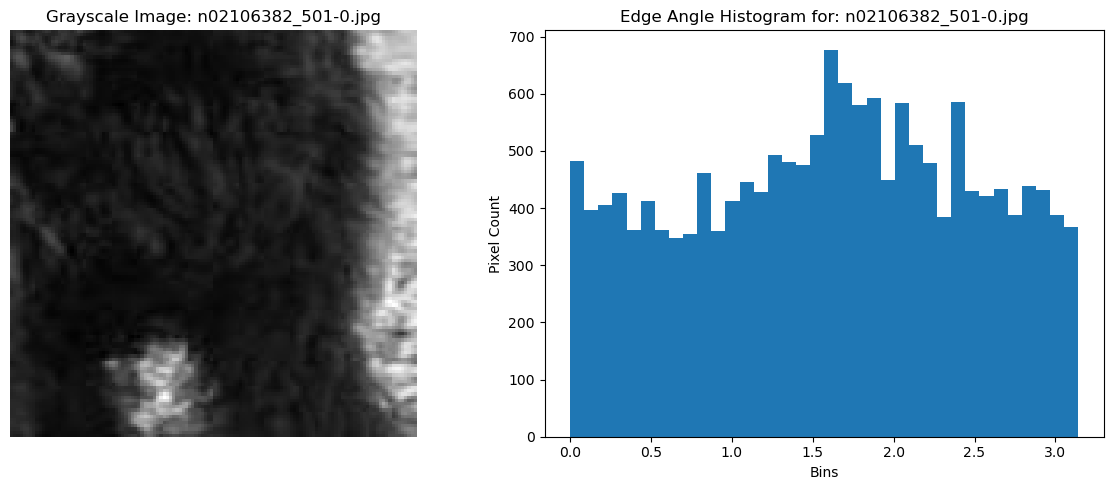

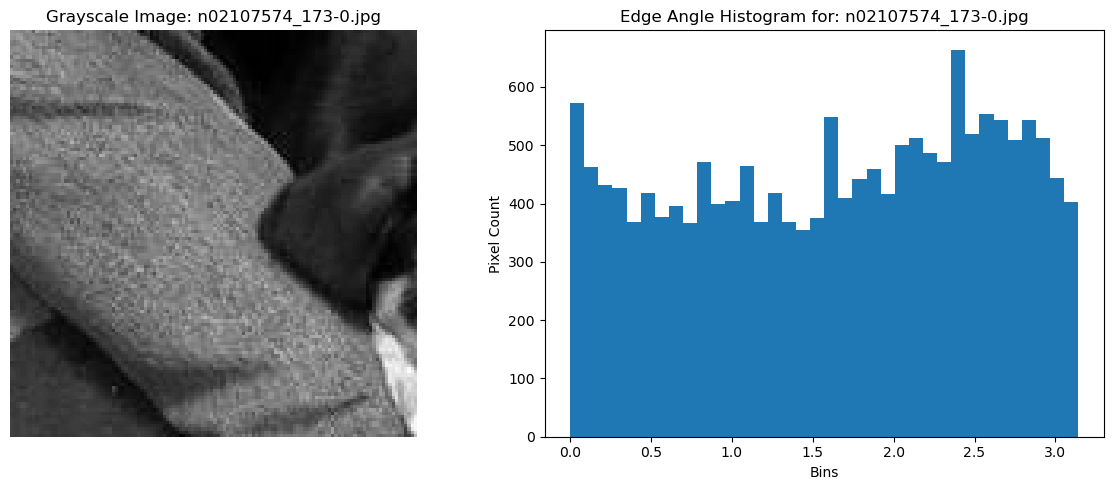

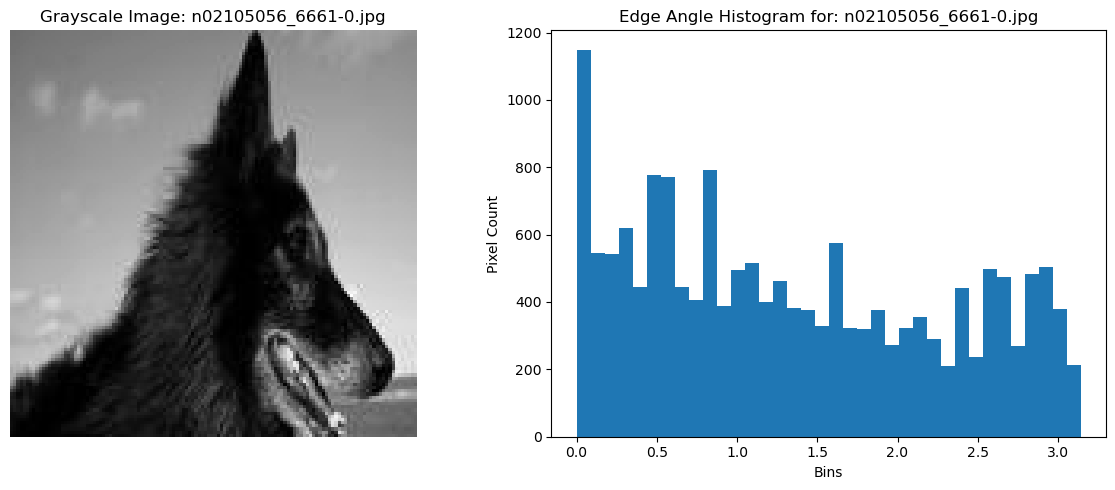

In [17]:
# Iterate over selected images and plot the edge histograms
for class_name, images in selected_images.items():
    for img_path in images:
        process_image_for_histogram(img_path)  # Process and plot histogram

### Computing distances between two histograms

In [18]:
# Function to compute distances between two histograms
def compare_histograms(hist1, hist2):
    hist1 = np.array(hist1).reshape(1, -1)  # Convert to 2D array
    hist2 = np.array(hist2).reshape(1, -1)  # Convert to 2D array

    # Compute Euclidean distance
    euclidean_dist = pairwise_distances(hist1, hist2, metric='euclidean')[0][0]

    # Compute Manhattan distance
    manhattan_dist = pairwise_distances(hist1, hist2, metric='manhattan')[0][0]

    # Compute Cosine distance
    cosine_dist = pairwise_distances(hist1, hist2, metric='cosine')[0][0]

    return euclidean_dist, manhattan_dist, cosine_dist

In [19]:
# Function to process and return the edge histogram for comparison
def get_edge_histogram(image_path):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)

    sobel_h = filters.sobel_h(img_np)
    sobel_v = filters.sobel_v(img_np)

    # Calculating the angle for each pixel
    angle_sobel = angle(sobel_h, sobel_v)

    # Compute the histogram with 36 bins for the angles
    hist, hist_centers = exposure.histogram(angle_sobel, nbins=36)
    return hist, hist_centers

In [20]:
# Function to display two images and their histograms
def display_images_with_histograms(img1_path, img2_path, hist1, hist2):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Image 1
    axs[0, 0].imshow(img1)
    axs[0, 0].set_title(f'{img1_path.name} - Original Image')
    axs[0, 0].axis('off')

    # Plot Image 2
    axs[0, 1].imshow(img2)
    axs[0, 1].set_title(f'{img2_path.name} - Original Image')
    axs[0, 1].axis('off')

    # Plot Histogram of Image 1
    axs[1, 0].bar(range(len(hist1)), hist1, width=0.8, color='gray')
    axs[1, 0].set_title(f'{img1_path.name} - Edge Histogram')
    axs[1, 0].set_xlabel('Bins')
    axs[1, 0].set_ylabel('Pixel Count')

    # Plot Histogram of Image 2
    axs[1, 1].bar(range(len(hist2)), hist2, width=0.8, color='gray')
    axs[1, 1].set_title(f'{img2_path.name} - Edge Histogram')
    axs[1, 1].set_xlabel('Bins')
    axs[1, 1].set_ylabel('Pixel Count')

    plt.tight_layout()
    plt.show()


### Picking 2 edge histograms from the 4 constructed and Perform histogram comparison using the metrics/measures.

Comparison between n02102318_10162-0.jpg and n02106382_501-0.jpg:
Euclidean Distance: 789.6860135522219
Manhattan Distance: 3118.0
Cosine Distance: 0.03957624533831949


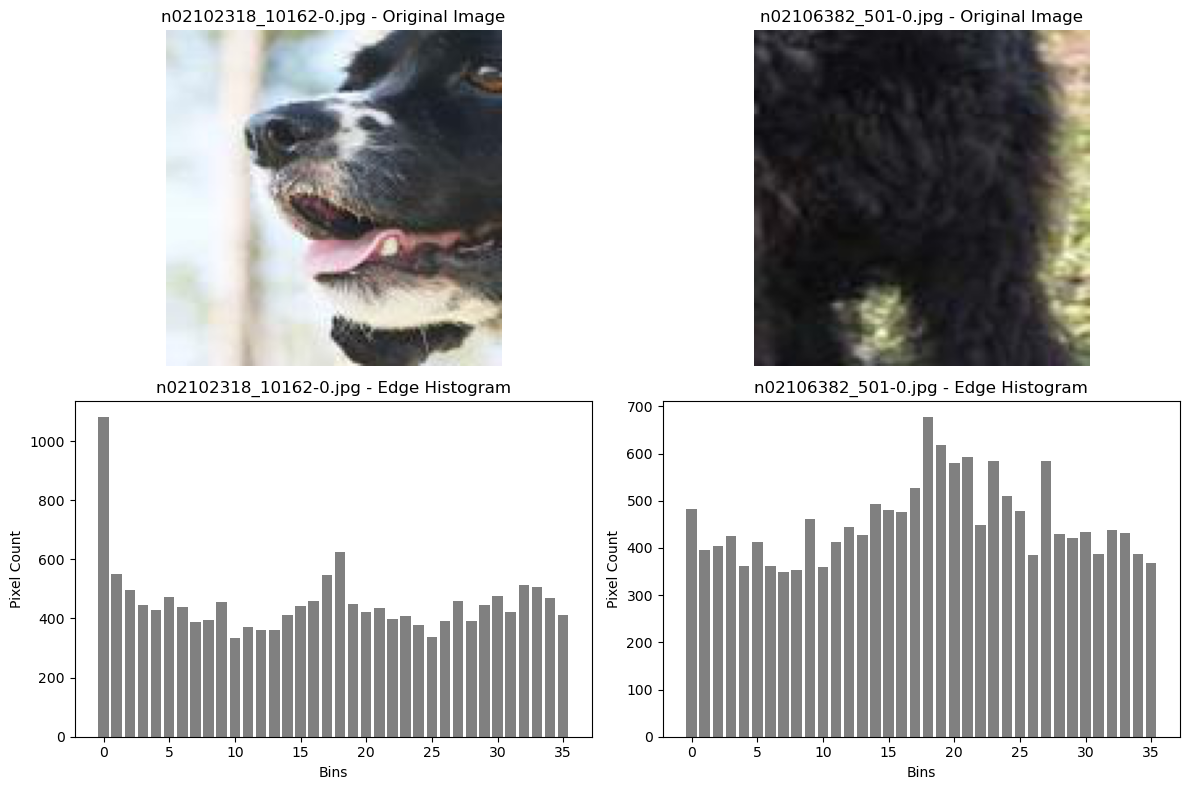

In [21]:
 #Select 2 images from the cropped dataset
img1_path = selected_images["n02102318-cocker_spaniel"][0]
img2_path = selected_images["n02106382-Bouvier_des_Flandres"][0]

# Get histograms and histogram centers of the 2 selected images
hist1, hist_centers1 = get_edge_histogram(img1_path)
hist2, hist_centers2 = get_edge_histogram(img2_path)

# Compare histograms using the defined metrics
euclidean, manhattan, cosine = compare_histograms(hist1, hist2)

# Output the results
print(f"Comparison between {img1_path.name} and {img2_path.name}:")
print(f"Euclidean Distance: {euclidean}")
print(f"Manhattan Distance: {manhattan}")
print(f"Cosine Distance: {cosine}")

# Display the images and histograms
display_images_with_histograms(img1_path, img2_path, hist1, hist2)

### (c) Histogram of Oriented Gradient (HOG) feature descriptor

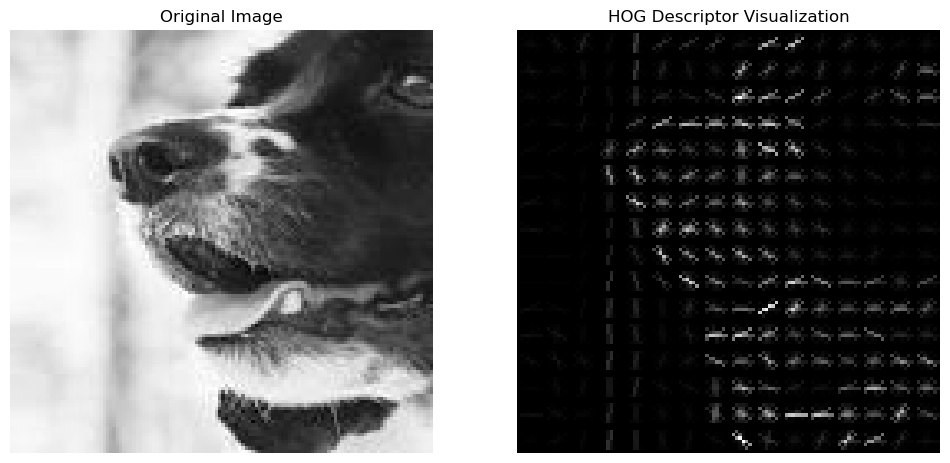

In [22]:
from skimage.feature import hog

# Function to compute and visualize HOG descriptors
def compute_and_visualize_hog(image_path):
    # Read the image
    img = io.imread(image_path, as_gray=True)

    # Compute HOG descriptors and HOG image
    hog_descriptors, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                                     cells_per_block=(2, 2), visualize=True, multichannel=False)

    # Rescale HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Plot the original image and HOG visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # HOG Image
    axs[1].imshow(hog_image_rescaled, cmap='gray')
    axs[1].set_title('HOG Descriptor Visualization')
    axs[1].axis('off')

    plt.show()

    return hog_descriptors

# Select an image from the dataset
image_path = selected_images["n02102318-cocker_spaniel"][0]

# Compute and visualize HOG descriptors
hog_descriptors = compute_and_visualize_hog(image_path)

### (d) Dimensionality reduction (using Principal Component Analysis, PCA)

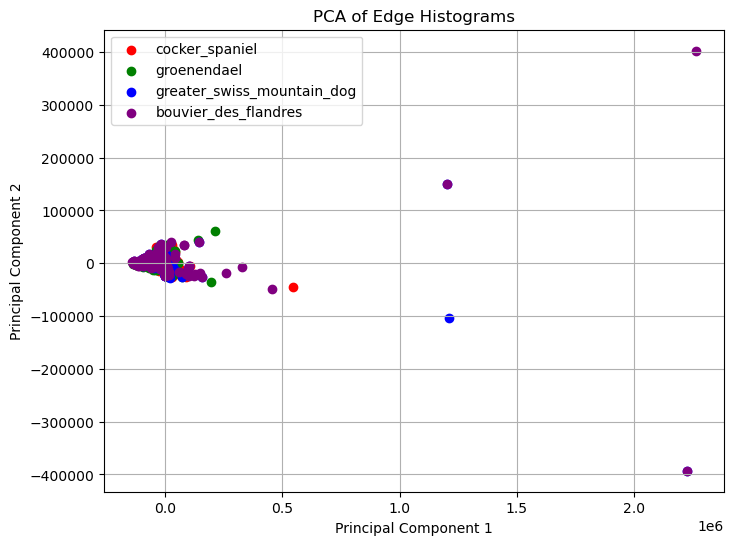

In [37]:
from sklearn.decomposition import PCA
from skimage import io, feature

# Define the base path for the images
base_path = '/Users/apple/Downloads/data_mining/Images'

# Function to calculate edge histogram
def calculate_edge_histogram(image):
    edges = feature.canny(image, sigma=1.0)  # Calculate edges using Canny edge detector
    histogram, _ = np.histogram(edges, bins=36, range=(0, 1))  # Create histogram with 36 bins
    return histogram

edge_histograms = []

# Read images and calculate edge histograms
for label, image_paths in selected_images.items():
    for image_path in image_paths:
        img = io.imread(image_path, as_gray=True)  # Load the image as grayscale
        hist = calculate_edge_histogram(img)  # Calculate edge histogram
        edge_histograms.append(hist)

# Convert list of histograms to a numpy array for PCA
edge_histograms = np.array(edge_histograms)

# Perform PCA to reduce dimensionality from 36 to 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(edge_histograms)

# Plotting the results
plt.figure(figsize=(8, 6))
colors = {'cocker_spaniel': 'red', 'groenendael': 'green', 'greater_swiss_mountain_dog': 'blue', 'bouvier_des_flandres': 'purple'}
for i, (label, image_paths) in enumerate(selected_images.items()):
    plt.scatter(reduced_data[i * len(image_paths):(i + 1) * len(image_paths), 0],
                reduced_data[i * len(image_paths):(i + 1) * len(image_paths), 1],
                c=colors[label], label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Edge Histograms')
plt.legend()
plt.grid()
plt.show()

### How many classes are visually separable? 
#### Two classes seem to be visually separable (`purple` and some `green` ). The remaining classes (probably represented by other colors) appear to overlap significantly and are not visually separable in the 2D PCA plot.

# Q3

# Load the dataset from the JSON file

In [24]:
train_file = '/Users/apple/Downloads/data_mining/student_21/train.json'
with open(train_file, 'r') as f:
    data = [json.loads(line) for line in f]

## Load the JSON data into a list

In [25]:
with open(train_file, 'r') as f:
    data = [json.loads(line) for line in f]

## Convert the list to a pandas DataFrame for easier manipulation


In [26]:
df = pd.DataFrame(data)
df.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-30414,"@Chr1sMcLaughlin he's brilliant, lost the joyo...",False,False,False,False,True,False,False,False,False,False,False
1,2017-En-10478,Now that @Jasmine_Wrn has snapchat back it's a...,False,False,False,False,True,False,False,False,False,False,False
2,2017-En-40274,@groovydadad @MHChat 🙂ty I often conflate the ...,False,False,False,False,False,False,False,False,True,False,False
3,2017-En-41471,Speech was bold coz it wasn't written by PM NS...,False,False,False,False,False,False,False,False,False,False,False
4,2017-En-30541,You have to find a way to top yourself. #glee,False,False,False,False,True,True,True,False,False,False,False


### Q3: Preprocessing the Data
#### I will focus on these four emotion classes: `anger`, `joy`, `fear`, and `trust`. 
#### First, we'll filter the dataset to include only tweets that are labeled with one of these emotions.

In [27]:
selected_classes = ['anger', 'joy', 'fear', 'trust']

# Filter rows where any of the selected classes are labeled as True
df_selected = df[(df[selected_classes].sum(axis=1) > 0)]

# Extract the tweet texts and the associated labels
X = df_selected['Tweet']  # The texts (tweets)
y = df_selected[selected_classes].idxmax(axis=1)  # The labels (emotion class)

### Display the first few rows of the filtered dataset

In [28]:
df_selected.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-30414,"@Chr1sMcLaughlin he's brilliant, lost the joyo...",False,False,False,False,True,False,False,False,False,False,False
1,2017-En-10478,Now that @Jasmine_Wrn has snapchat back it's a...,False,False,False,False,True,False,False,False,False,False,False
4,2017-En-30541,You have to find a way to top yourself. #glee,False,False,False,False,True,True,True,False,False,False,False
5,2017-En-20357,@jjskeffington @foodbelfast I dread to think!,False,False,False,True,False,False,False,True,True,False,False
6,2017-En-11203,@douglas_nat @one11north I need it today! Do u...,True,False,True,False,False,False,False,False,False,False,False


## 4. Feature Extraction 
### Using two methods to extract features from the tweet texts:
#### 1. **CountVectorizer**: Converts text data to a matrix of token counts.
#### 2. **TfidfVectorizer**: Converts text data to a matrix of TF-IDF values.

In [29]:
# (1) Token Counts using CountVectorizer
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(X)

In [30]:
# (2) TF-IDF using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

### Displaying the dimensionality of both vectorized feature sets


In [31]:
print(f'CountVectorizer Dimensions: {X_count.shape}')
print(f'TfidfVectorizer Dimensions: {X_tfidf.shape}')

CountVectorizer Dimensions: (2457, 8495)
TfidfVectorizer Dimensions: (2457, 8495)


### 5. Dimensionality Reduction 
#### To visualize the data, i reduced the dimensionality of the feature matrices to 2 dimensions using **Principal Component Analysis (PCA)**. This will allow us to plot the data in a 2D space.

In [32]:
# (1) PCA for CountVectorizer features
pca = PCA(n_components=2)
X_count_2d = pca.fit_transform(X_count.toarray())

In [33]:
# (2) PCA for TfidfVectorizer features
X_tfidf_2d = pca.fit_transform(X_tfidf.toarray())

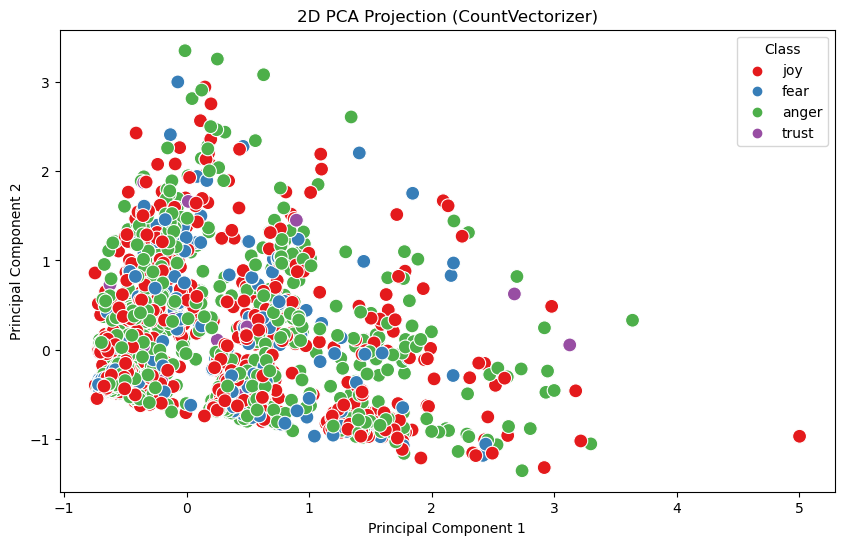

In [34]:
# (1) Plot for CountVectorizer features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_count_2d[:, 0], y=X_count_2d[:, 1], hue=y, palette='Set1', s=100)
plt.title('2D PCA Projection (CountVectorizer)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()

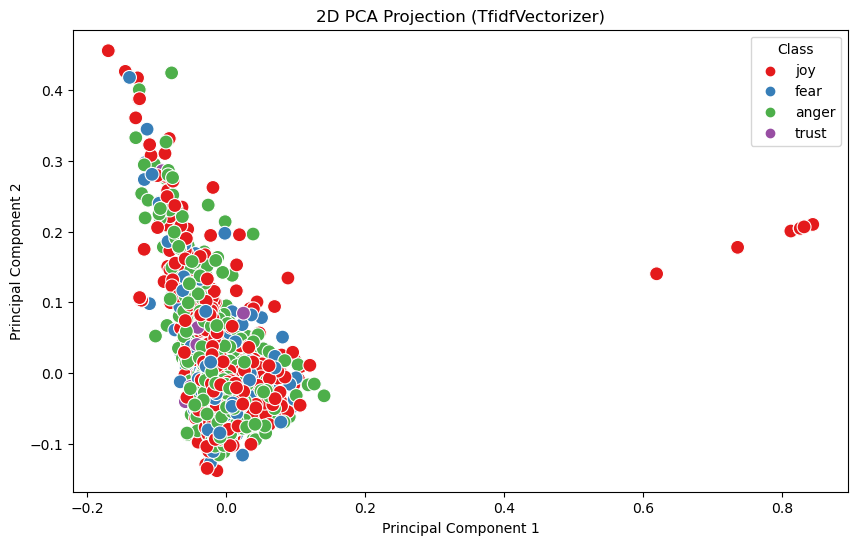

In [35]:
# (2) Plot for TfidfVectorizer features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tfidf_2d[:, 0], y=X_tfidf_2d[:, 1], hue=y, palette='Set1', s=100)
plt.title('2D PCA Projection (TfidfVectorizer)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()

### How many classes are visually separable (i.e., non-overlapping) for both plots?
##### By visualizing the 2D projections of the tweets, we can observe that:
##### - Some classes (e.g., `anger` and `joy`) may appear more separable, while others overlap more.
##### - The separation depends on the feature extraction method used. **CountVectorizer** tends to group tweets more tightly, whereas **TfidfVectorizer** shows a different spread.
